In [1]:
import sys

import pandas as pd
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k, rmse, mae, exp_var, rsquared
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

import matplotlib.pyplot as plt

System version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas version: 1.5.3
Tensorflow version: 2.11.0


<h1>Load data</h1>

In [3]:
dataset_name = 'sas'

In [4]:
train_file = "../data/{}/train.csv".format(dataset_name)
test_file = "../data/{}/test.csv".format(dataset_name)

train = pd.read_csv(train_file)
test  = pd.read_csv(test_file)

In [5]:
def deduplicate(df):
    min_v, max_v = df['rating'].min(), df['rating'].max()
    df = df.groupby(['userID', 'itemID'], as_index=False).agg({'rating': 'sum', 'timestamp': 'max'})
    df['rating'] = np.clip(df['rating'], min_v, max_v)
    return df

In [6]:
train = deduplicate(train)
test = deduplicate(test)

In [7]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation
am = AffinityMatrix(df = train, **header)
#obtain the sparse matrix, users x items
Xtr, u, i = am.gen_affinity_matrix()

In [8]:
Xtst = np.zeros_like(Xtr)
for indx, (user, item, rating, timestamp) in test.iterrows():
    u_index = u[user]
    i_index = i[item]

    Xtst[u_index][i_index] = rating

In [9]:
print('train matrix size', Xtr.shape)
print('test matrix size', Xtst.shape)

train matrix size (47759, 2184)
test matrix size (47759, 2184)


In [10]:
train['userID'].nunique(), train['itemID'].nunique()

(47759, 2184)

<h1>Train the RBM model</h1>

In [13]:
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
    visible_units=Xtr.shape[1],
    hidden_units=140,
    training_epoch=3,
    minibatch_size=70,
    keep_prob=0.75,
    with_metrics=True
)

2023-05-08 08:36:26.977501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-05-08 08:36:26.987524: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2023-05-08 08:36:28.059834: W tensorflow/c/c_api.cc:291] Operation '{name:'key_value_init/LookupTableImportV2' id:6 op device:{requested: '', assigned: ''} def:{{{node key_value_init/LookupTableImportV2}} = LookupTableImportV2[Tin=DT_INT32, Tout=DT_FLOAT, _has_manual_control_dependencies=true](hash_table, Const, Const_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Took 17.55 seconds for training.


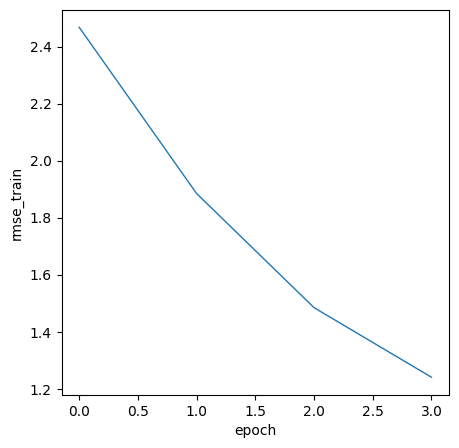

In [14]:
# Model Fit
with Timer() as train_time:
    model.fit(Xtr)

print("Took {:.2f} seconds for training.".format(train_time.interval))

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

In [19]:
# number of top score elements to be recommended
K = 100

# Model prediction on the test set Xtst.
with Timer() as prediction_time:
    top_k = model.recommend_k_items(Xtst, K, remove_seen=True)

print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))

Took 61.06 seconds for prediction.


In [20]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

<h1>Evaluation metrics</h1>

In [21]:
def ranking_metrics(data_true, data_pred, K):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    print("Model:\RBM",
      "Top K:\t%d" % K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

In [22]:
ranking_metrics(
    data_true=test_df,
    data_pred=top_k_df,
    K=10
)

Model:\RBM
Top K:	10
MAP:	0.023431
NDCG:	0.035362
Precision@K:	0.011025
Recall@K:	0.048190


In [387]:
merged = pd.merge(test_df, top_k_df, on=('userID', 'itemID'))

In [388]:
def rating_metrics(data_true, data_pred):
    
    eval_rmse = rmse(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
    eval_mae = mae(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
    eval_exp_var = exp_var(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
    eval_rsquared = rsquared(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")


    print("Model:\RBM rating prediction",
      "RMSE:\t%f" % eval_rmse,
      "MAE:\t%f" % eval_mae,
      "Explained variance:\t%f" % eval_exp_var,
      "R squared:\t%f" % eval_rsquared, sep='\n')

In [389]:
rating_metrics(
    data_true=merged[['userID', 'itemID', 'rating']],
    data_pred=merged[['userID', 'itemID', 'prediction']],
)

Model:\RBM rating prediction
RMSE:	1.038982
MAE:	0.890258
Explained variance:	-0.078920
R squared:	-0.765922


<h3>SAS RFM</h3>

In [27]:
from copy import deepcopy

In [23]:
rfm = pd.read_parquet('../data/sas/mart/rfm_mapped.parquet')
rfm_levels = ["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]

In [28]:
merged_pred = deepcopy(top_k_df)
merged_test = deepcopy(test_df)

In [32]:
ndcg_at_k(merged_test, merged_pred, col_prediction='prediction', k=10)

0.03536224882605439

In [29]:
TOP_K = 10
NDCGs = []
for level in rfm_levels:
    users = rfm[rfm['RFM_Level'] == level]['phone'].unique()

    m_test_s = merged_test[merged_test['userID'].isin(users)]
    m_pred_s = merged_pred[merged_pred['userID'].isin(users)]

    print(m_test_s.shape, m_pred_s.shape)

    eval_map = map_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)

    NDCGs.append(eval_ndcg)

(5532, 3) (283600, 3)
(3455, 3) (289700, 3)
(4055, 3) (425000, 3)
(4344, 3) (584900, 3)
(2694, 3) (510600, 3)
(572, 3) (193200, 3)


In [33]:
for level, ndcg in zip(rfm_levels, NDCGs):
    print(level, np.round(ndcg, 4))

Can't Loose Them 0.0253
Champions 0.0224
Loyal 0.0202
Potential 0.0268
Sleeping 0.0323
Require Activation 0.03


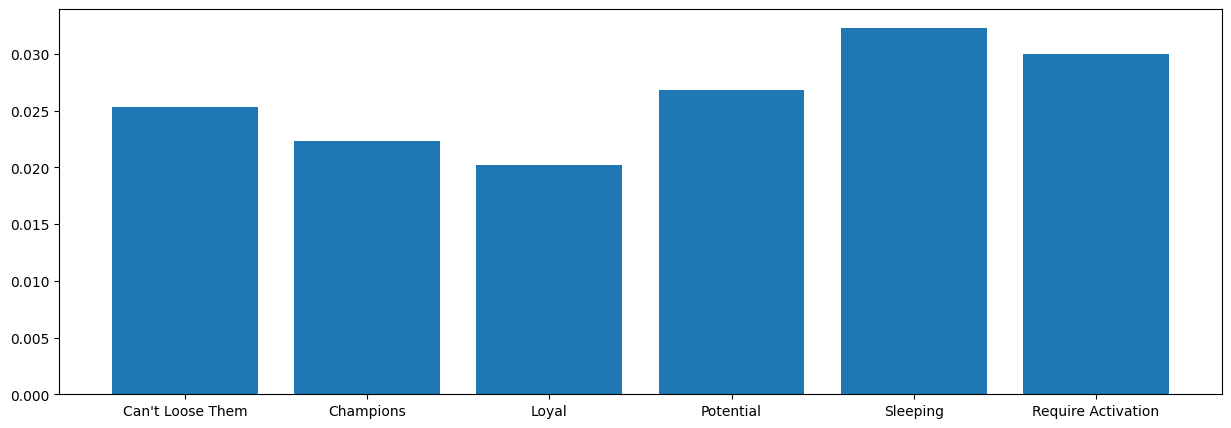

In [31]:
plt.figure(figsize=(15,5))
plt.bar(rfm_levels, NDCGs);

<h1>Saving the model and Loading a pre-trained model</h1>

In [ ]:
#model.save(file_path='./models/rbm_model.ckpt')